In [1]:
import numpy as np                        # ndarrys for gridded data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
import cv2 
import random
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
import glob
import keras
from PIL import Image
import json
import os
import gc
from tqdm import notebook, tnrange
import tifffile as tiff
from sklearn.model_selection import train_test_split
import time
import datetime
from skimage.transform import resize
# import tensorflow as tf; tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


In [2]:
!nvidia-smi

Tue May 19 08:16:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 26%   40C    P0    62W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   39C    P0    64W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
os.chdir("/home/ahadmomin/project")

In [4]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probs of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)


def build_iou_for(label: int, name: str=None):
    """
    Build an Intersection over Union (IoU) metric for a label.
    Args:
        label: the label to build the IoU metric for
        name: an optional name for debugging the built method
    Returns:
        a keras metric to evaluate IoU for the given label
        
    Note:
        label and name support list inputs for multiple labels
    """
    # handle recursive inputs (e.g. a list of labels and names)
    if isinstance(label, list):
        if isinstance(name, list):
            return [build_iou_for(l, n) for (l, n) in zip(label, name)]
        return [build_iou_for(l) for l in label]

    # build the method for returning the IoU of the given label
    def label_iou(y_true, y_pred):
        """
        Return the Intersection over Union (IoU) score for {0}.
        Args:
            y_true: the expected y values as a one-hot
            y_pred: the predicted y values as a one-hot or softmax output
        Returns:
            the scalar IoU value for the given label ({0})
        """.format(label)
        return iou(y_true, y_pred, label)

    # if no name is provided, us the label
    if name is None:
        name = label
    # change the name of the method for debugging
    label_iou.__name__ = 'iou_{}'.format(name)

    return label_iou
        

def mean_iou(y_true, y_pred):
    """
    Return the Intersection over Union (IoU) score.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
    Returns:
        the scalar IoU value (mean over all labels)
    """
    # get number of labels to calculate IoU for
    num_labels = K.int_shape(y_pred)[-1]
    # initialize a variable to store total IoU in
    total_iou = K.variable(0)
    # iterate over labels to calculate IoU for
    for label in range(num_labels):
        total_iou = total_iou + iou(y_true, y_pred, label)
    # divide total IoU by number of labels to get mean IoU
    return total_iou / num_labels


smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [5]:

def create_numpyset(path_X ='/k',
                    path_y = '/k',
                    new_path_X= 'train_numpy/',
                    new_path_y='train_numpy/'):
    
    X=[]
    y=[]
    
    ids = next(os.walk(path_X))[1]
    print("Numnber of images = ", len(ids))    
    
    for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
        
        names_R=(path_X+id_+"/tomo/"+id_+".tif")
        names_y=(path_X+id_+"/seg/"+id_+".tif")
        print(names_R)
        print(names_y)
        X.append(cv2.resize(cv2.imread(names_R,1),(512,512)))
        y.append(cv2.resize(cv2.imread(names_y,-1),(512,512)))

    X= (X - np.min(X)) / (np.max(X) - np.min(X))
    print(X, X.shape)
    
    y= to_categorical(y).astype(np.uint8)
    
    X= X.astype(np.float16)
    print(X.shape)
    print(y.shape)    
        
    try:
        os.mkdir(new_path_X + '/X' )
        os.mkdir(new_path_y + '/y' )
    except: 
        print('folder exits')
    
    for im_num in range( np.shape(X)[0] ):
        np.save( new_path_X + '/X/' + f'{im_num}', X[im_num,:,:,:]  )
        np.save( new_path_y + '/y/' + f'{im_num}', y[im_num,:,:,:]  )

In [6]:
# create_numpyset(path_X ='stage2_train2D/',
#                     path_y = '/stage2_train2D',
#                     new_path_X= 'train_numpy/',
#                     new_path_y='train_numpy/')

In [7]:
num_gpus =3
total_samples=2400
batch_size=6
epochs =50
train_ids = np.arange(0, total_samples)
image_dims = (512,512)
filters_first_layer = 64
## Validation Data Size
val_data_size = 263
validation_split=0.2
file_loc= 'train_numpy/'

In [8]:
all_dirs = glob.glob(file_loc + '/X/*.npy')

X_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],3)).astype(np.float32)
y_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],4)).astype(np.int8)

for im_num in notebook.tqdm(range( len(all_dirs) )):
    
    X_train[im_num,:,:,:] = np.load( file_loc + f'/X/{im_num}.npy' )
    y_train[im_num,:,:,:] = np.load( file_loc + f'/y/{im_num}.npy' )

Text(0.5, 1.0, 'Segmented(GR)-Phase4')

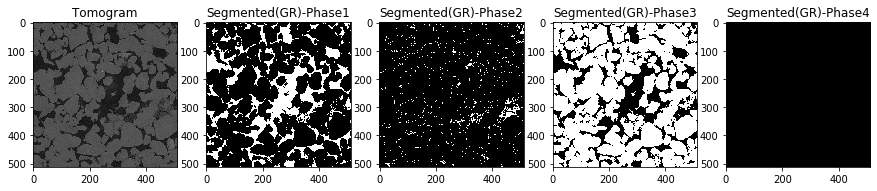

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (15, 15))
ax1.imshow(X_train[3].astype('float32'))
ax1.set_title('Tomogram')
ax2.imshow((y_train[3,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)-Phase1')
ax3.imshow((y_train[3,...,1]), cmap = 'gray')
ax3.set_title('Segmented(GR)-Phase2')
ax4.imshow((y_train[3,...,2]), cmap = 'gray')
ax4.set_title('Segmented(GR)-Phase3')
ax5.imshow((y_train[3,...,3]), cmap = 'gray')
ax5.set_title('Segmented(GR)-Phase4')

Text(0.5, 1.0, 'Segmented(GR)-Phase4')

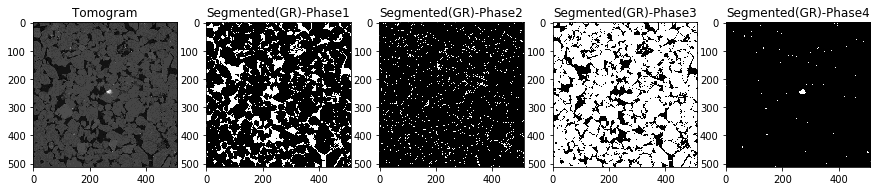

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (15, 15))
ax1.imshow(X_train[4,...,0], cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_train[4,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)-Phase1')
ax3.imshow((y_train[4,...,1]), cmap = 'gray')
ax3.set_title('Segmented(GR)-Phase2')
ax4.imshow((y_train[4,...,2]), cmap = 'gray')
ax4.set_title('Segmented(GR)-Phase3')
ax5.imshow((y_train[4,...,3]), cmap = 'gray')
ax5.set_title('Segmented(GR)-Phase4')

Text(0.5, 1.0, 'Segmented(GR)-Phase4')

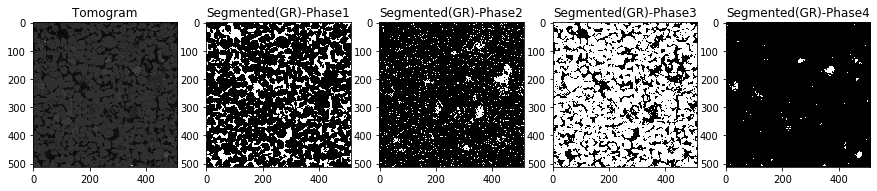

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (15, 15))
ax1.imshow(X_train[5,...,0], cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_train[5,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)-Phase1')
ax3.imshow((y_train[5,...,1]), cmap = 'gray')
ax3.set_title('Segmented(GR)-Phase2')
ax4.imshow((y_train[5,...,2]), cmap = 'gray')
ax4.set_title('Segmented(GR)-Phase3')
ax5.imshow((y_train[5,...,3]), cmap = 'gray')
ax5.set_title('Segmented(GR)-Phase4')

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=2020)

In [24]:
print("Tomogram dimension in Training = ", X_train.shape,X_train.dtype)
print("Segmented dimension in Training  = ",y_train.shape, y_train.dtype)
print("Tomogram dimension in Testing = ",X_valid.shape, X_valid.dtype)
print("Segmented dimension in Testing = ",y_valid.shape, y_valid.dtype)

Tomogram dimension in Training =  (1920, 512, 512, 3) float32
Segmented dimension in Training  =  (1920, 512, 512, 4) int8
Tomogram dimension in Testing =  (480, 512, 512, 3) float32
Segmented dimension in Testing =  (480, 512, 512, 4) int8


In [25]:
def Unet2D(featuremaps):
        inputs = keras.layers.Input(shape=(image_dims[0], image_dims[1], 3))

        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(inputs)
        conv1 = batch_Norm_Activation(conv1)
        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(conv1)
        conv1 = batch_Norm_Activation(conv1)
        pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)

        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(pool1)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv2)
        conv2 = batch_Norm_Activation(conv2)
        pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)

        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(pool2)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3),padding="same")(conv3)
        conv3 = batch_Norm_Activation(conv3)
        pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)

        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(pool3)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv4)
        conv4 = batch_Norm_Activation(conv4)
        pool4 = keras.layers.MaxPooling2D((2, 2))(conv4)

        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(pool4)
        convm = batch_Norm_Activation(convm)
        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)

        deconv4 = keras.layers.Conv2DTranspose(featuremaps * 8, (2, 2), strides=(2, 2), padding="same")(convm)
        uconv4 = keras.layers.concatenate([deconv4, conv4])
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)

        deconv3 = keras.layers.Conv2DTranspose(featuremaps * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
        uconv3 = keras.layers.concatenate([deconv3, conv3])
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)

        deconv2 = keras.layers.Conv2DTranspose(featuremaps * 2, (2, 2), strides=(2, 2), padding="same")(uconv3)
        uconv2 = keras.layers.concatenate([deconv2, conv2])
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)

        deconv1 = keras.layers.Conv2DTranspose(featuremaps * 1, (2, 2), strides=(2, 2), padding="same")(uconv2)
        uconv1 = keras.layers.concatenate([deconv1, conv1])
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)

        output_layer = keras.layers.Conv2D(4, (1,1), padding="same", activation= 'softmax')(uconv1)
        model = keras.models.Model(inputs, output_layer)
        
        return model
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x= keras.layers.Activation("relu")(x)
    return x



In [26]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [27]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Unet2D(64)
    metrics=[ 'accuracy', iou_loss, mean_iou] 
    model.compile( loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-04), metrics=metrics[:])

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 512, 512, 64) 0           conv2d_20[0][0]                  
_____________________________________________________________________________________________

In [21]:
from sklearn.utils.class_weight import compute_class_weight
  
def sample_weight(y):
        y_integers    = np.argmax(y, axis=3)
        class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers.flatten() )
        print(class_weights)
        d_class_weights = dict(enumerate(class_weights))
    
        sample_weight = np.zeros((np.shape(y_integers)[0])) 
        for sample in range(np.shape( sample_weight)[0] ):
            frac_0 = np.sum( y_integers[sample,:,:]==0 )/np.size(y_integers[sample,:,:])
            frac_1 = np.sum( y_integers[sample,:,:]==1 )/np.size(y_integers[sample,:,:])
            frac_2 = np.sum( y_integers[sample,:,:]==2 )/np.size(y_integers[sample,:,:])
            frac_3 = np.sum( y_integers[sample,:,:]==3 )/np.size(y_integers[sample,:,:])
    
            sample_weight[sample] = frac_0*d_class_weights[0]+frac_1*d_class_weights[1]+frac_2*d_class_weights[2]+ \
                                    frac_3*d_class_weights[3]
        return sample_weight

In [18]:
hist_model = model.fit( x=X_train, y=y_train, epochs=epochs, batch_size=batch_size,
                       validation_data = (X_valid, y_valid, sample_weight(y_valid)), verbose=1, 
                       callbacks=callbacks, 
                       sample_weight=sample_weight(y_train),
                       shuffle=True )

[ 1.17628006  4.79334128  0.34224215 51.72831244]
[ 1.1713383   4.75305833  0.34293869 50.22166256]
Train on 1920 samples, validate on 480 samples
Epoch 1/50
1920/1920 [==============================] - 252s 131ms/step - loss: 0.3044 - accuracy: 0.8882 - iou_loss: 0.4968 - mean_iou: 0.2637 - val_loss: 0.1857 - val_accuracy: 0.9451 - val_iou_loss: 0.6839 - val_mean_iou: 0.3996

Epoch 00001: val_loss improved from inf to 0.18574, saving model to model-unet.h5
Epoch 2/50
1920/1920 [==============================] - 250s 130ms/step - loss: 0.1321 - accuracy: 0.9579 - iou_loss: 0.8088 - mean_iou: 0.4329 - val_loss: 0.1025 - val_accuracy: 0.9651 - val_iou_loss: 0.8538 - val_mean_iou: 0.4629

Epoch 00002: val_loss improved from 0.18574 to 0.10252, saving model to model-unet.h5
Epoch 3/50
1920/1920 [==============================] - 248s 129ms/step - loss: 0.0977 - accuracy: 0.9666 - iou_loss: 0.8608 - mean_iou: 0.4889 - val_loss: 0.0807 - val_accuracy: 0.9710 - val_iou_loss: 0.8820 - val_mean

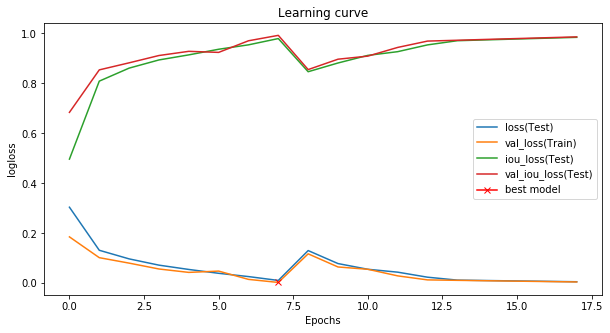

In [19]:
plt.figure(figsize=(10, 5))
plt.title("Learning curve")
plt.plot(hist_model.history["loss"], label="loss(Test)")
plt.plot(hist_model.history["val_loss"], label="val_loss(Train)")
plt.plot(hist_model.history["iou_loss"], label="iou_loss(Test)")
plt.plot(hist_model.history["val_iou_loss"], label="val_iou_loss(Test)")
plt.plot(np.argmin(hist_model.history["val_loss"]), np.min(hist_model.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("logloss")
plt.legend();

In [28]:
model.load_weights('model-unet.h5')
preds_train =np.argmax(model.predict(X_train[0:20], verbose=1),axis=3)
preds_test = np.argmax(model.predict(X_valid[0:20], verbose=1),axis=3)
print(preds_train.shape,preds_test.shape)

20/20 [==============================] - 1s 39ms/step
(20, 512, 512) (20, 512, 512)


AttributeError: 'Model' object has no attribute 'history'

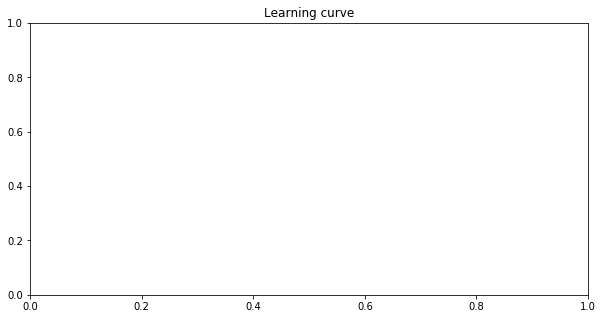

In [29]:
plt.figure(figsize=(10, 5))
plt.title("Learning curve")
plt.plot(model.history["loss"], label="loss(Test)")

## def plot_sample(X, y, preds, r=None):
    if r is None:
        r = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 6, figsize=(35, 10))
    ax[0].imshow(X[r])
    print(X[r,...,2].shape)
    ax[0].set_title('tomogram')

    ax[2].imshow(np.argmax(y[r],axis=2))
    print(np.argmax(y[r],axis=2).shape)
    ax[2].set_title('Segmented(GR)')

    ax[1].imshow(preds[r])
    print(preds[r].shape,preds[r])
    ax[1].set_title('Prediction')
    
    ax[3].hist(X[r].ravel(), bins=30)
    ax[3].set_title('Histogram_of_original_tomogram')
    ax[4].hist(preds[r].ravel(), bins=30)
    ax[4].set_title('Histogram_of_original_segmented')
    ax[5].hist(np.argmax(y[r],axis=2).ravel(), bins=30)
    ax[5].set_title('Histogram_of_multiOtsu_segmentation')

(512, 512)
(512, 512)
(512, 512) [[2 2 2 ... 0 0 0]
 [2 2 2 ... 1 0 0]
 [2 2 2 ... 1 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


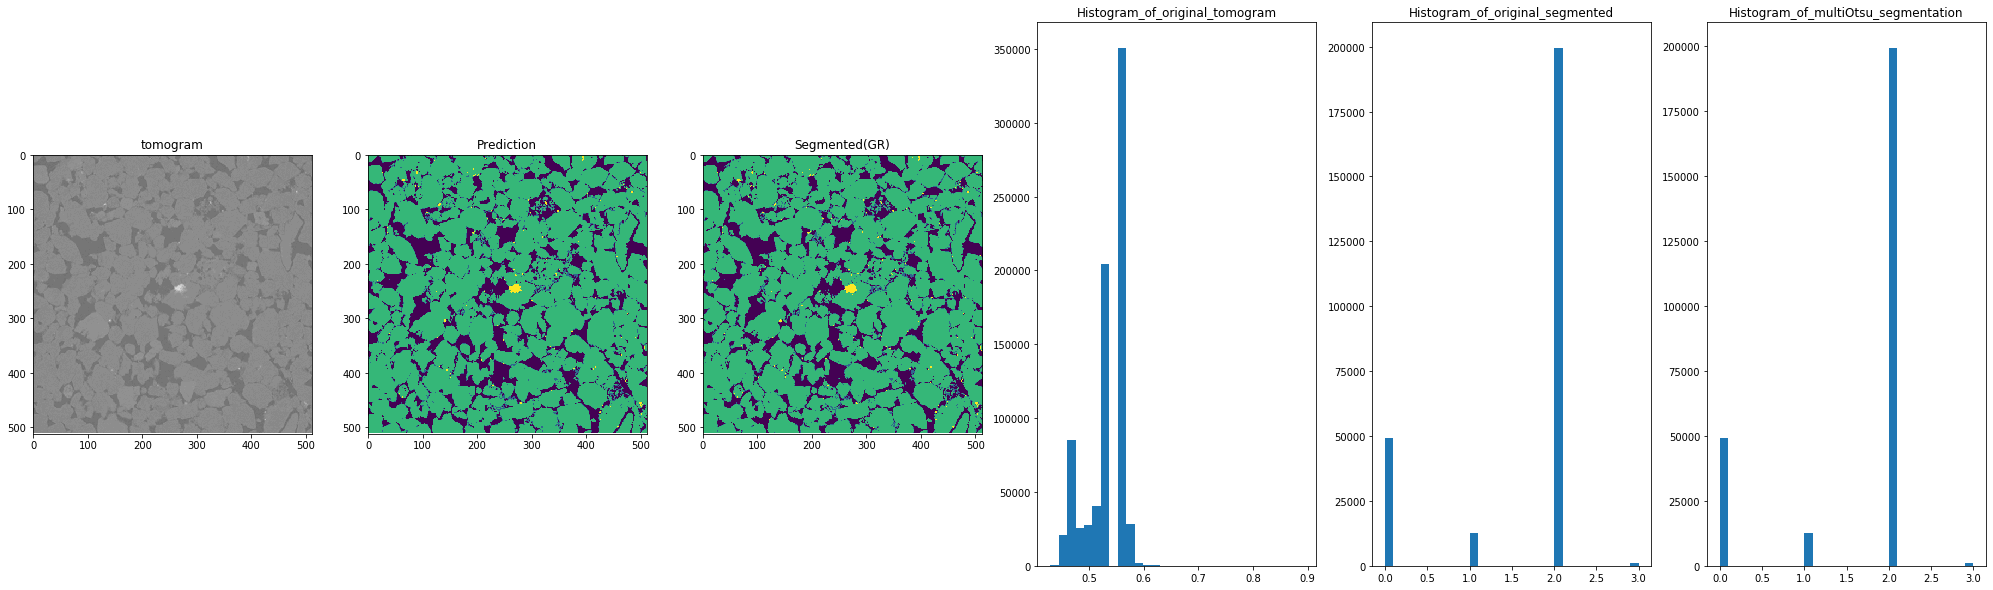

In [22]:
plot_sample(X_train, y_train, preds_train, r=18)

(512, 512)
(512, 512)
(512, 512) [[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


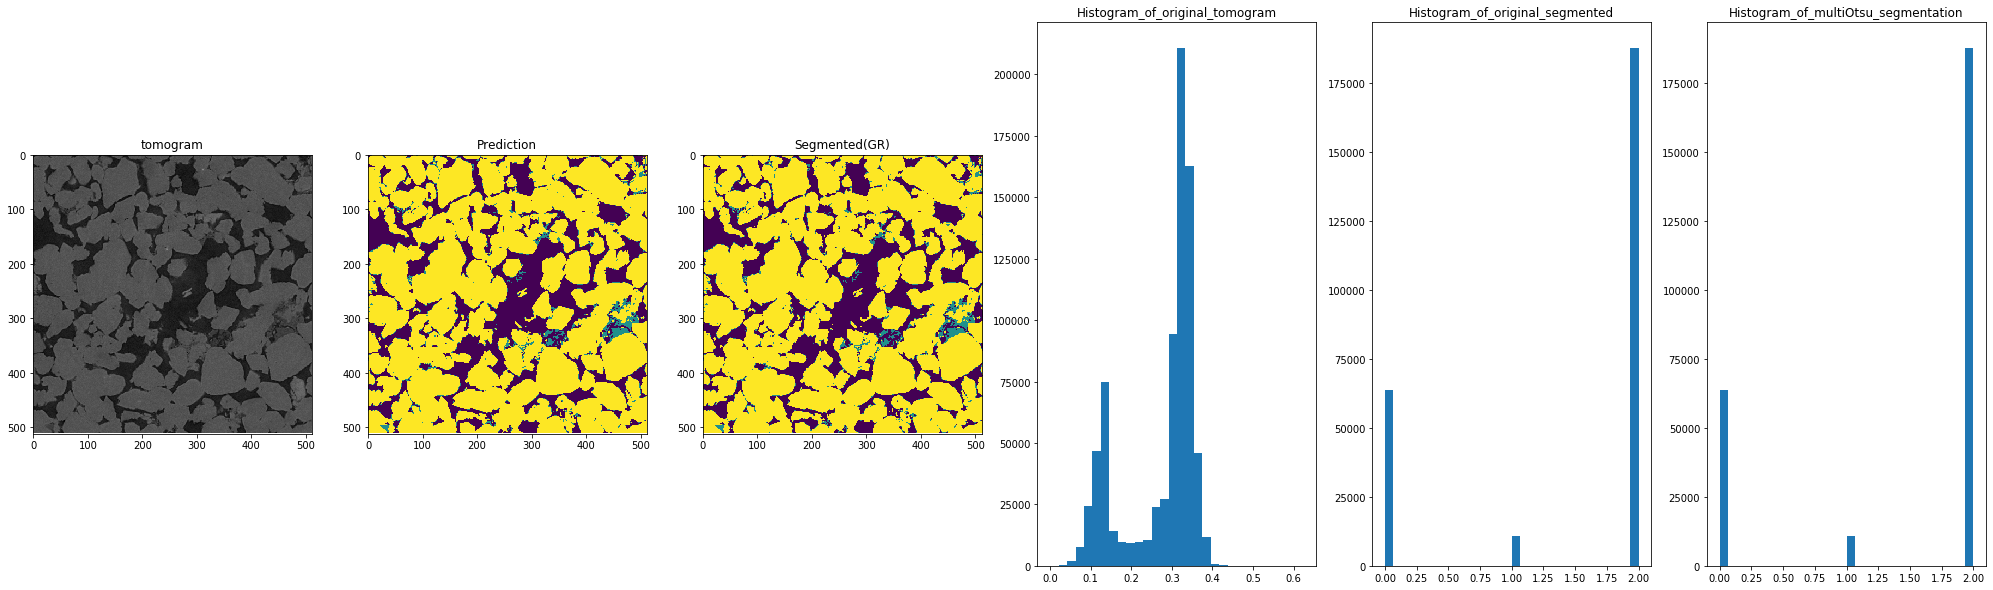

In [23]:
plot_sample(X_valid, y_valid, preds_test, r=17)

(512, 512)
(512, 512)
(512, 512) [[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [0 0 1 ... 2 2 2]
 [0 0 1 ... 2 2 2]
 [0 0 2 ... 2 2 2]]


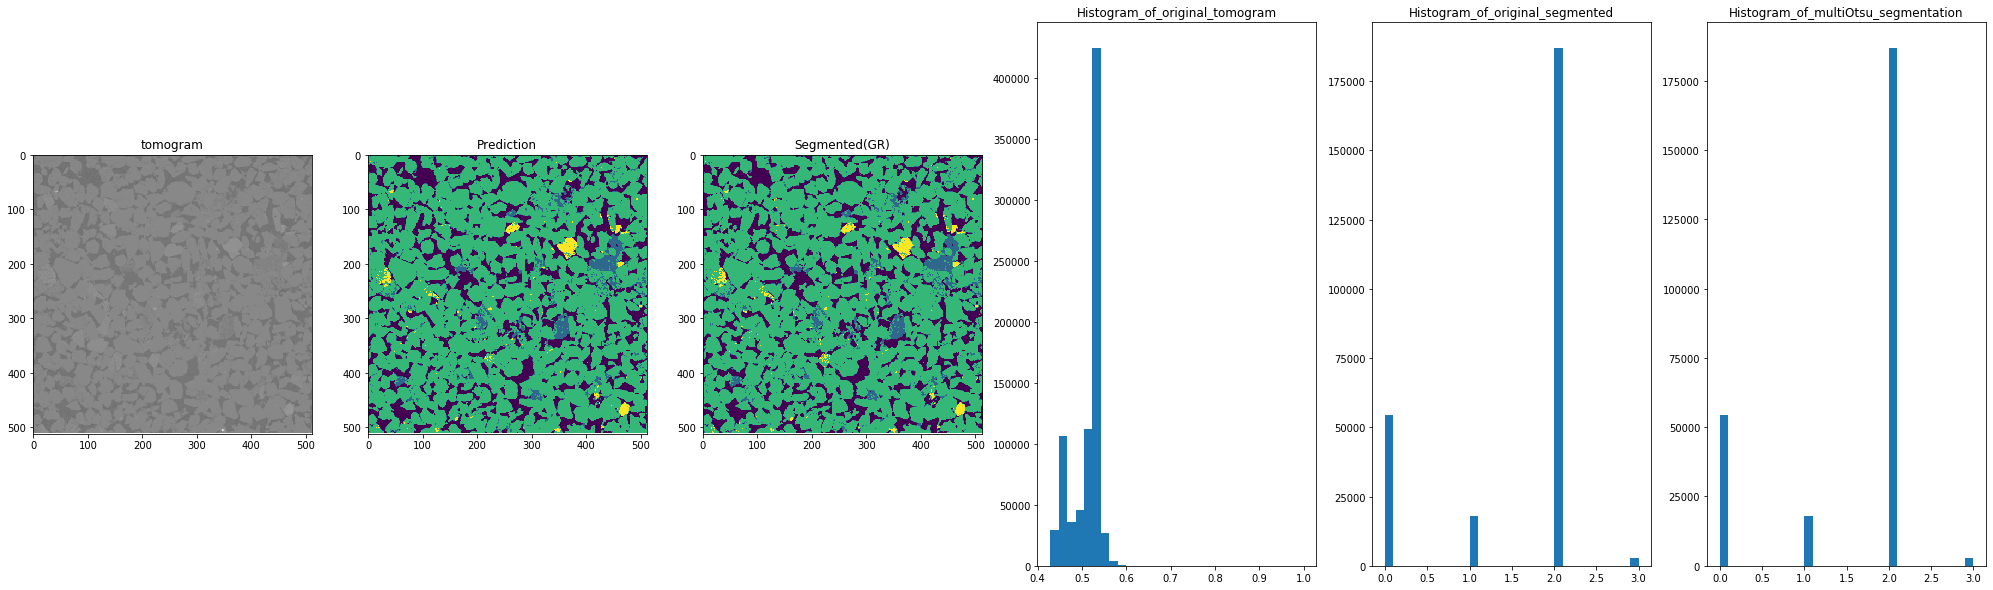

In [24]:
plot_sample(X_valid, y_valid, preds_test, r=16)

In [1]:
os.chdir("/home/ahadmomin/data/stage2_train2D/1200/tomo/")
unseen1 = cv2.imread('1200.tif')
os.chdir("/home/ahadmomin/data/stage2_train2D/1200/seg/")
label1 = cv2.imread('1200.tif',-1)
label1=  cv2.resize(label1,(512,512))
label1=to_categorical(label1).astype(np.int8)
unseen1 = cv2.resize(unseen1,(512,512))
unseen1 = (unseen1 - np.min(unseen1)) / (np.max(unseen1) - np.min(unseen1))
from medpy.filter.smoothing import anisotropic_diffusion
unseen1 = anisotropic_diffusion(unseen1,3)
kernel = np.ones((5,5), np.uint8) 
unseen1 = cv2.erode(unseen1, kernel, iterations=2) 
unseen1 = cv2.dilate(unseen1, kernel, iterations=1) 
unseen = np.expand_dims(unseen1,axis=0)
unseen = unseen.astype(np.float32)
print(unseen.shape, unseen.dtype, label1.shape, label1.dtype)

NameError: name 'os' is not defined

In [ ]:
lol_test = np.argmax(model.predict(unseen, verbose=1),axis=3)
print(lol_test.shape,lol_test.dtype)

In [ ]:
import scipy 
plt.imshow(unseen1)

In [ ]:
lol_test = model.predict(unseen, verbose=1)
lol_test=np.squeeze(lol_test,axis=0)
# lol_test=np.expand_dims(lol_test,axis=2)
lol_test = cv2.erode(lol_test, kernel, iterations=2) 
lol_test = cv2.dilate(lol_test, kernel, iterations=3) 
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
ax[0].imshow(np.argmax(lol_test, axis=2)>0)
ax[0].set_title('prediction')
ax[1].hist(np.argmax(lol_test, axis=2).ravel(), bins=30)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
ax[0].imshow(np.argmax(label1*-1,axis=2))
ax[0].set_title('prediction')
ax[1].hist(np.argmax(label1*-1,axis=2).ravel(), bins=30